In [119]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm 
from discopro.grammar import tensor
from lambeq import BobcatParser, NumpyModel, AtomicType, Rewriter, Dataset, QuantumTrainer, SPSAOptimizer , AtomicType, IQPAnsatz, RemoveCupsRewriter
from lambeq.backend.grammar import Spider
from lambeq.rewrite import UnifyCodomainRewriter
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Ty
from tqdm import tqdm
import random
import datetime
from discopro.anaphora import connect_anaphora_on_top
from contextuality.model import Model, Scenario, CyclicScenario

In [172]:
remove_cups = RemoveCupsRewriter()

parser = BobcatParser()
rewriter = Rewriter(['auxiliary',
                     'connector',
                     'coordination',
                     'determiner',
                     'object_rel_pronoun',
                     'subject_rel_pronoun',
                     'postadverb',
                     'preadverb',
                     'prepositional_phrase'])

N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE 

ansatz = IQPAnsatz({N: 1, S: 1, P:1}, n_layers=1, n_single_qubit_params=3) 

In [3]:
def generate_diagram(diagram, pro, ref):

    pro_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == pro.casefold())
    ref_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == ref.casefold())
    final_diagram = connect_anaphora_on_top(diagram, pro_box_idx, ref_box_idx)
    rewritten_diagram = rewriter(remove_cups(final_diagram)).normal_form()
    return rewritten_diagram

In [4]:
def sent2dig(sentence1: str, sentence2: str, pro: str, ref: str):
    diagram1 = parser.sentence2diagram(sentence1)
    diagram2 = parser.sentence2diagram(sentence2)
    diagram = tensor(diagram1,diagram2)
    #diagram = diagram >> Spider(S, 2, 1)
    diagram = generate_diagram(diagram, pro, ref)
    #merger = UnifyCodomainRewriter(Ty('s'))
    #diagram = merger(diagram)
    return diagram

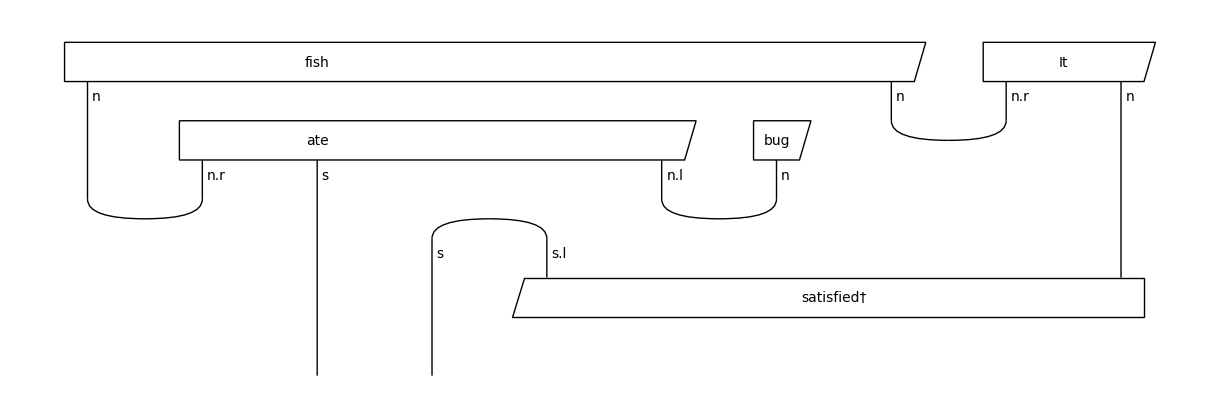

In [5]:
tmp = sent2dig("The fish ate the bug", "It was satisfied", "It", "fish").draw(space=10,figsize=(12,4))

In [6]:
def gen_labels(df: pd.DataFrame):
    circuits, labels, diagrams = [],[],[]
    selected_cols = [random.choice(['referent', 'wrong_referent']) for i in range(len(df))]

    #for i, row in tqdm(df.iterrows(), total=len(df)):
    for i in range(10):
        row = df.iloc[i]
        ref1 = row[selected_cols[i] + '1']
        ref2 = row[selected_cols[i] + '2']
        #label = [1.0, 0.0] if i % 2 == 0 else [0.0, 1.0]
        label = [1.0, 0.0] if selected_cols[i] == 'referent' else [0.0, 1.0]
        sent1, sent21, sent22, pro = row[['sentence1', 'sentence21', 'sentence22', 'pronoun']]
        #sent21 = sent21.replace(pro, 'The ' + ref1)
        #sent22 = sent22.replace(pro, 'The' + ref2)

        try:
            diagram1 = sent2dig(sent1.strip(), sent21.strip())
            diagram2 = sent2dig(sent1.strip(), sent22.strip())
            diagrams.append((diagram1, diagram2))
            discopy_circuit1 = ansatz(diagram1)
            discopy_circuit2 = ansatz(diagram2)
            circuits.append((discopy_circuit1, discopy_circuit2))
            labels.append((label,label))
        except Exception as e:
            # Print an error message if an exception occurs
            print("An error occurred:", e)

    return circuits, labels, diagrams

In [7]:
def gen_labels(df: pd.DataFrame):
    circuits, labels, diagrams = [],[],[]
    selected_cols = [random.choice(['referent', 'wrong_referent']) for i in range(len(df))]
    for i, row in tqdm(df.iterrows(), total=len(df)):
        ref = row[selected_cols[i]]
        label = [[0.25, 0.25],[0.25, 0.25]] if selected_cols[i] == 'referent' else [[0.25, 0.25],[0.25, 0.25]]
        sent1, sent2, pro = row[['sentence1', 'sentence2', 'pronoun']]

        try:
            diagram = sent2dig(sent1.strip(), sent2.strip(), pro.strip(), ref.strip())
            diagrams.append(diagram)
            circ = ansatz(diagram)
            circuits.append(circ)
            labels.append(label)
        except Exception as e:
            print("Error: ", e)
    return circuits, labels, diagrams

In [8]:
# df_train = pd.read_csv('dataset/train_60.csv', index_col=0)
# df_val = pd.read_csv('dataset/valid_20.csv', index_col=0)
# df_test = pd.read_csv('dataset/test_20.csv', index_col=0)
df_train = pd.read_csv('dataset/original_data/train.csv', index_col=0)
df_val = pd.read_csv('dataset/original_data/val.csv', index_col=0)
df_test = pd.read_csv('dataset/original_data/test.csv', index_col=0)

In [9]:
train_circuits, train_labels, train_diagrams = gen_labels(df_train[:10])
val_circuits, val_labels, val_diagrams = gen_labels(df_val[:10])
test_circuits, test_labels, test_diagrams = gen_labels(df_test[:10])

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.72it/s]


Error:  Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)


 20%|████████▊                                   | 2/10 [00:00<00:03,  2.59it/s]

Error:  Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)


 50%|██████████████████████                      | 5/10 [00:01<00:01,  2.59it/s]

Error:  Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.59it/s]


In [11]:
from pytket.circuit.display import render_circuit_jupyter
tket_circuit = train_circuits[0].to_tk()
render_circuit_jupyter(tket_circuit)

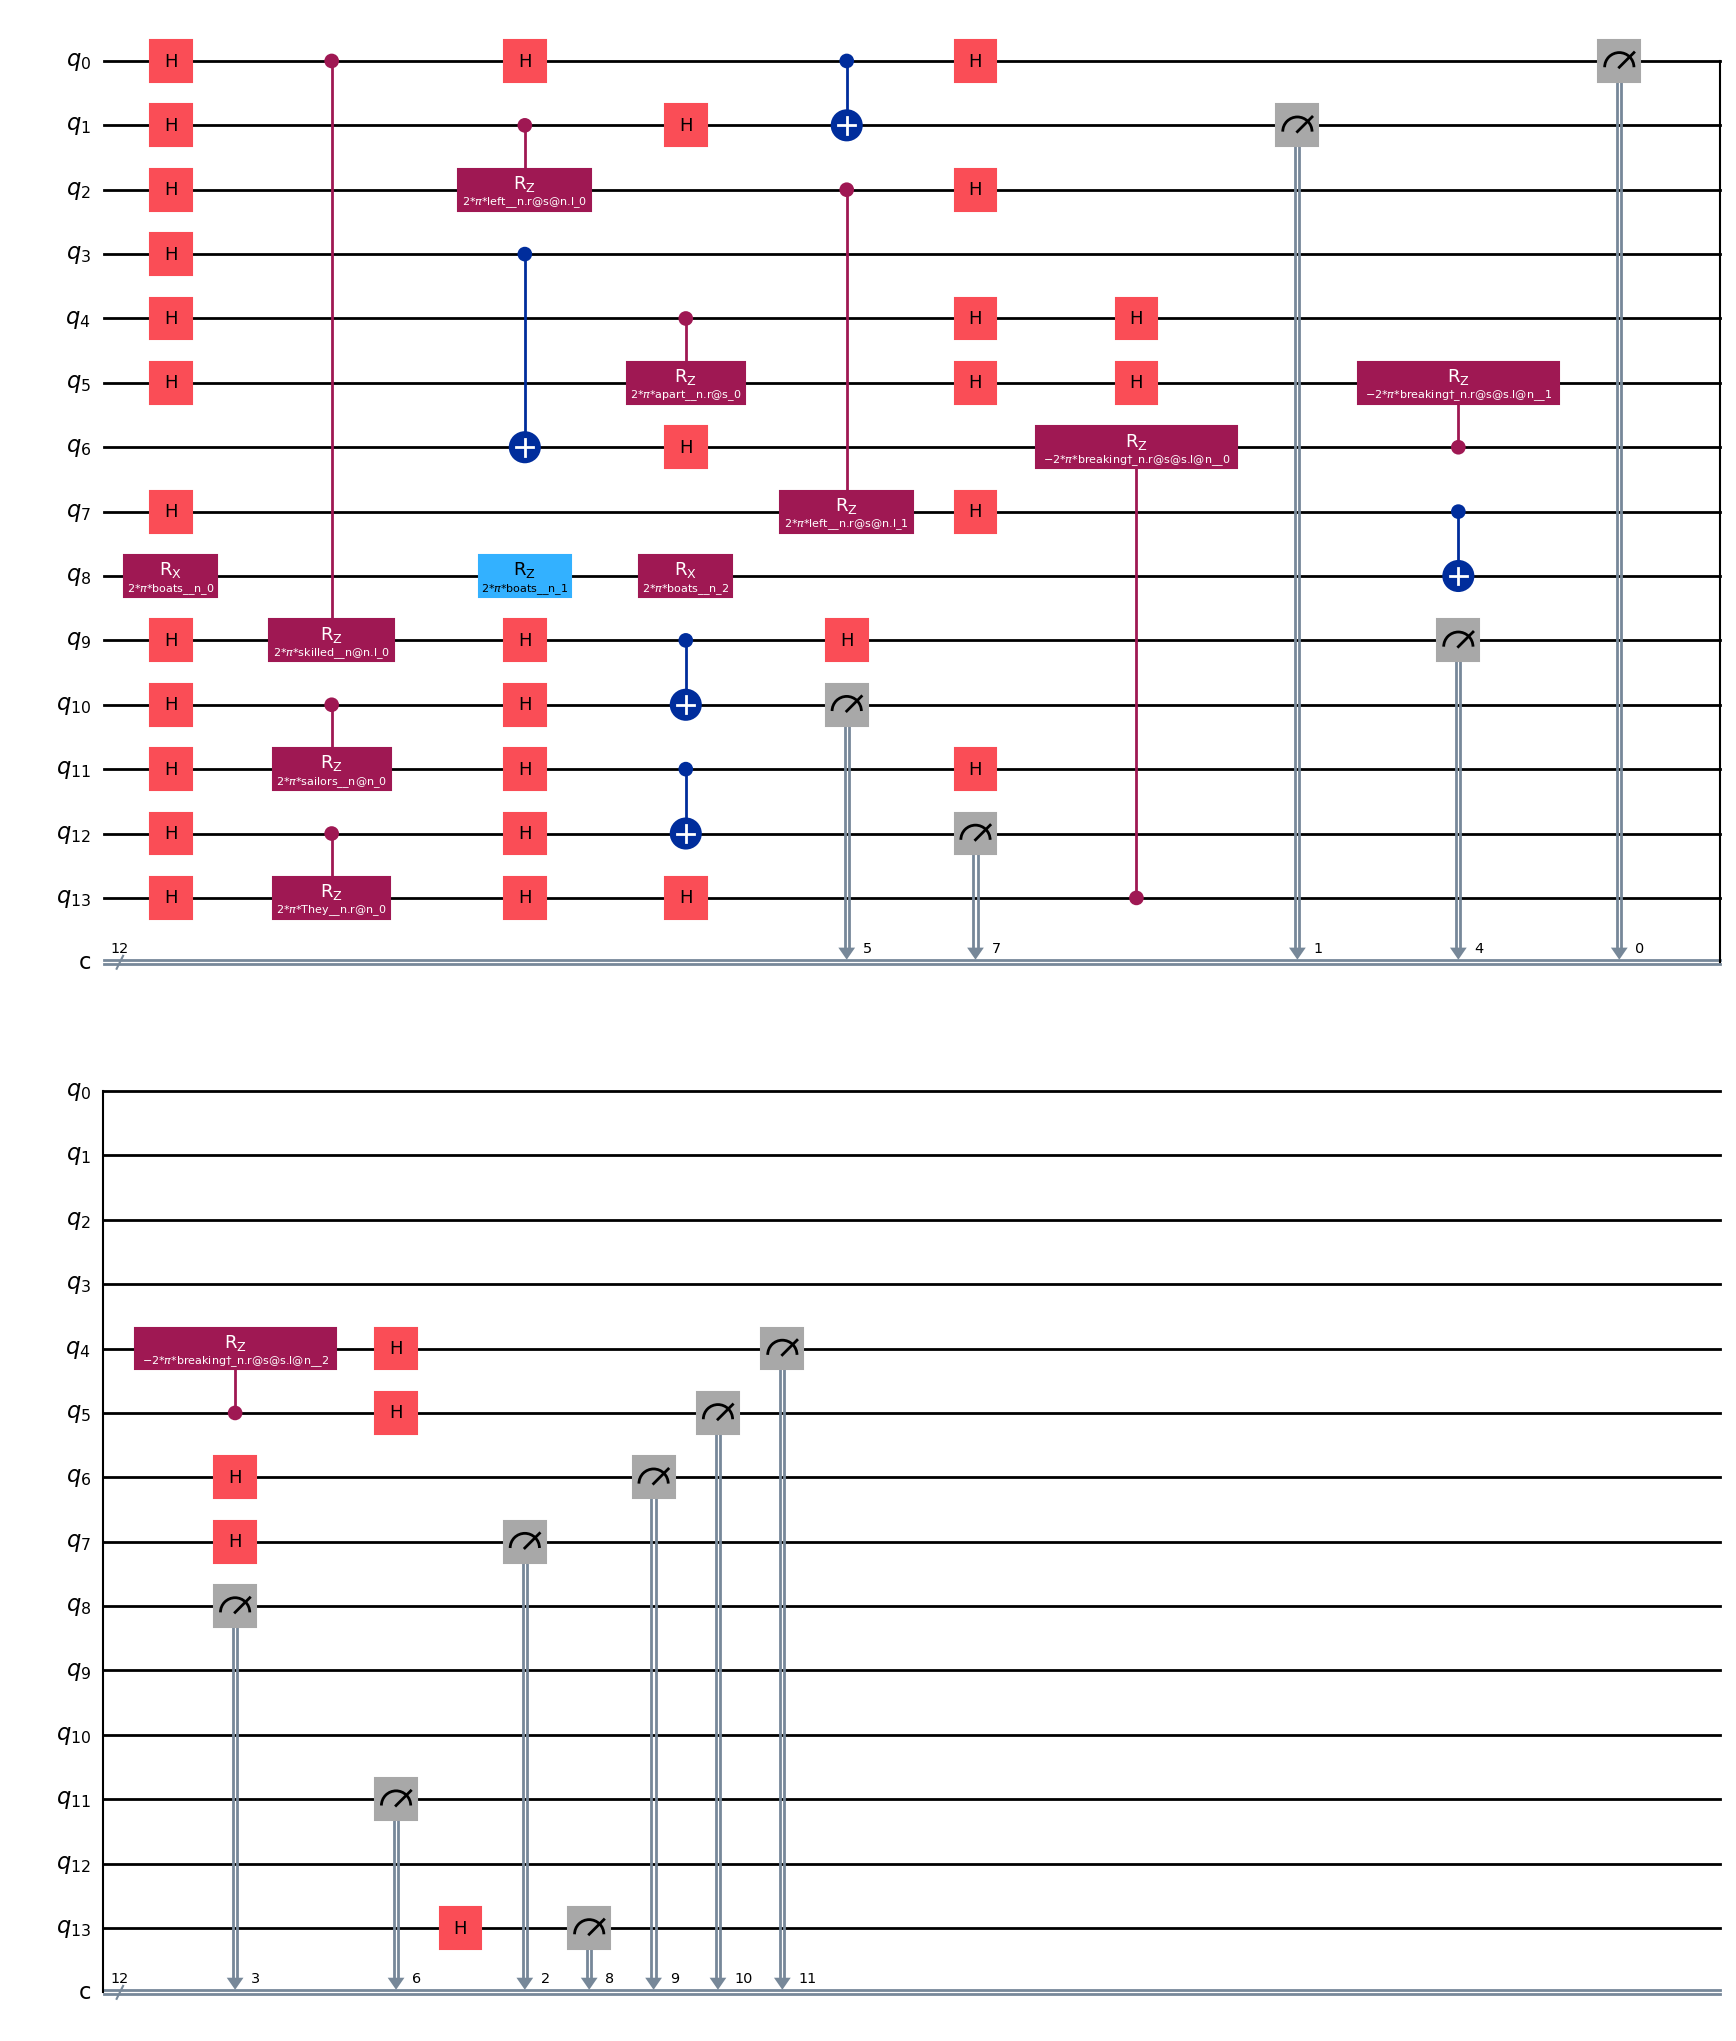

In [12]:
from pytket.extensions.qiskit import tk_to_qiskit
tk_to_qiskit(tket_circuit).draw(output="mpl")

In [15]:
from lambeq.training import BinaryCrossEntropyLoss
all_circuits = train_circuits + val_circuits + test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
#loss = BinaryCrossEntropyLoss(sparse=False)
acc = lambda y_hat, y: np.sum(np.round(y_hat) == np.array(y)) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [16]:
# def BinaryCrossEntropy(y_pred, y_true):
#     term_0 = (1-y_true) * np.log(1-y_pred)
#     term_1 = y_true * np.log(y_pred)
#     return -np.mean(term_0+term_1)
# loss = BinaryCrossEntropy

In [17]:
def main(EPOCHS: int, SEED: int, BATCH_SIZE: int) -> None:

    trainer = QuantumTrainer(
        model,
        loss_function=loss,
        epochs=EPOCHS,
        optimizer=SPSAOptimizer,
        optim_hyperparams={'a': 0.1, 'c': 0.06, 'A': 0.01 * EPOCHS},
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

    train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
    val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

    now = datetime.datetime.now()
    t = now.strftime("%Y-%m-%d_%H_%M_%S")
    print(t)
    trainer.fit(train_dataset, val_dataset, eval_interval=1, log_interval=1)
    test_acc = acc(model(test_circuits), test_labels)
    print('Test accuracy:', test_acc)

In [18]:
seed_arr = [0, 10, 50, 77, 100, 111, 150, 169, 200, 234, 250, 300, 350, 400, 450]
B_sizes = [2]
epochs_arr = [2000]

In [19]:
SEED = random.choice(seed_arr)
BATCH_SIZE = 5
EPOCHS = 100

In [20]:
main(EPOCHS, SEED, BATCH_SIZE)

2024-06-24_11_38_30


Epoch 1:    train/loss: 2.0708   valid/loss: 2.0953   train/acc: 0.0000   valid/acc: 0.0000
Epoch 2:    train/loss: 2.6281   valid/loss: 2.2248   train/acc: 0.0000   valid/acc: 0.0000
Epoch 3:    train/loss: 2.2596   valid/loss: 2.2039   train/acc: 0.0000   valid/acc: 0.0000
Epoch 4:    train/loss: 1.9308   valid/loss: 2.3315   train/acc: 0.0000   valid/acc: 0.0000
Epoch 5:    train/loss: 2.1854   valid/loss: 2.1598   train/acc: 0.0000   valid/acc: 0.0000
Epoch 6:    train/loss: 1.6929   valid/loss: 1.6994   train/acc: 0.0000   valid/acc: 0.0000
Epoch 7:    train/loss: 1.9222   valid/loss: 1.7456   train/acc: 0.0000   valid/acc: 0.0000
Epoch 8:    train/loss: 1.6860   valid/loss: 1.7193   train/acc: 0.0000   valid/acc: 0.0000
Epoch 9:    train/loss: 1.7124   valid/loss: 1.7598   train/acc: 0.0000   valid/acc: 0.0000
Epoch 10:   train/loss: 1.7697   valid/loss: 1.8517   train/acc: 0.0000   valid/acc: 0.0000
Epoch 11:   train/loss: 1.7684   valid/loss: 1.7285   train/acc: 0.0000   valid/

Test accuracy: 0.0


In [ ]:
for SEED in seed_arr:
    for BATCH_SIZE in B_sizes:
        for EPOCHS in epochs_arr:
            print(EPOCHS, SEED, BATCH_SIZE)
            main(EPOCHS, SEED, BATCH_SIZE)

In [96]:
s1, s2, p, n = df_train.iloc[0][['sentence1','sentence2','pronoun','referent']]
print(s1, s2, p, n)

The skilled sailors left the boats They were breaking apart They boats


In [97]:
best_model = NumpyModel.from_checkpoint('runs/Jun18_11-50-11_TLS-MBP.local/best_model.lt')
best_model.initialise_weights() 

In [147]:
diag = ansatz(sent2dig(s1, s2, p, n))

In [148]:
from qiskit.circuit.library import RYGate, HGate
from lambeq.backend.quantum import Box, qubit, SelfConjugate, Ry, Diagram
#ry = RYGate(0).to_matrix()
RY = Ry(0)
h = HGate().to_matrix()
H = Box(name='H',dom=qubit,cod=qubit,data=h)

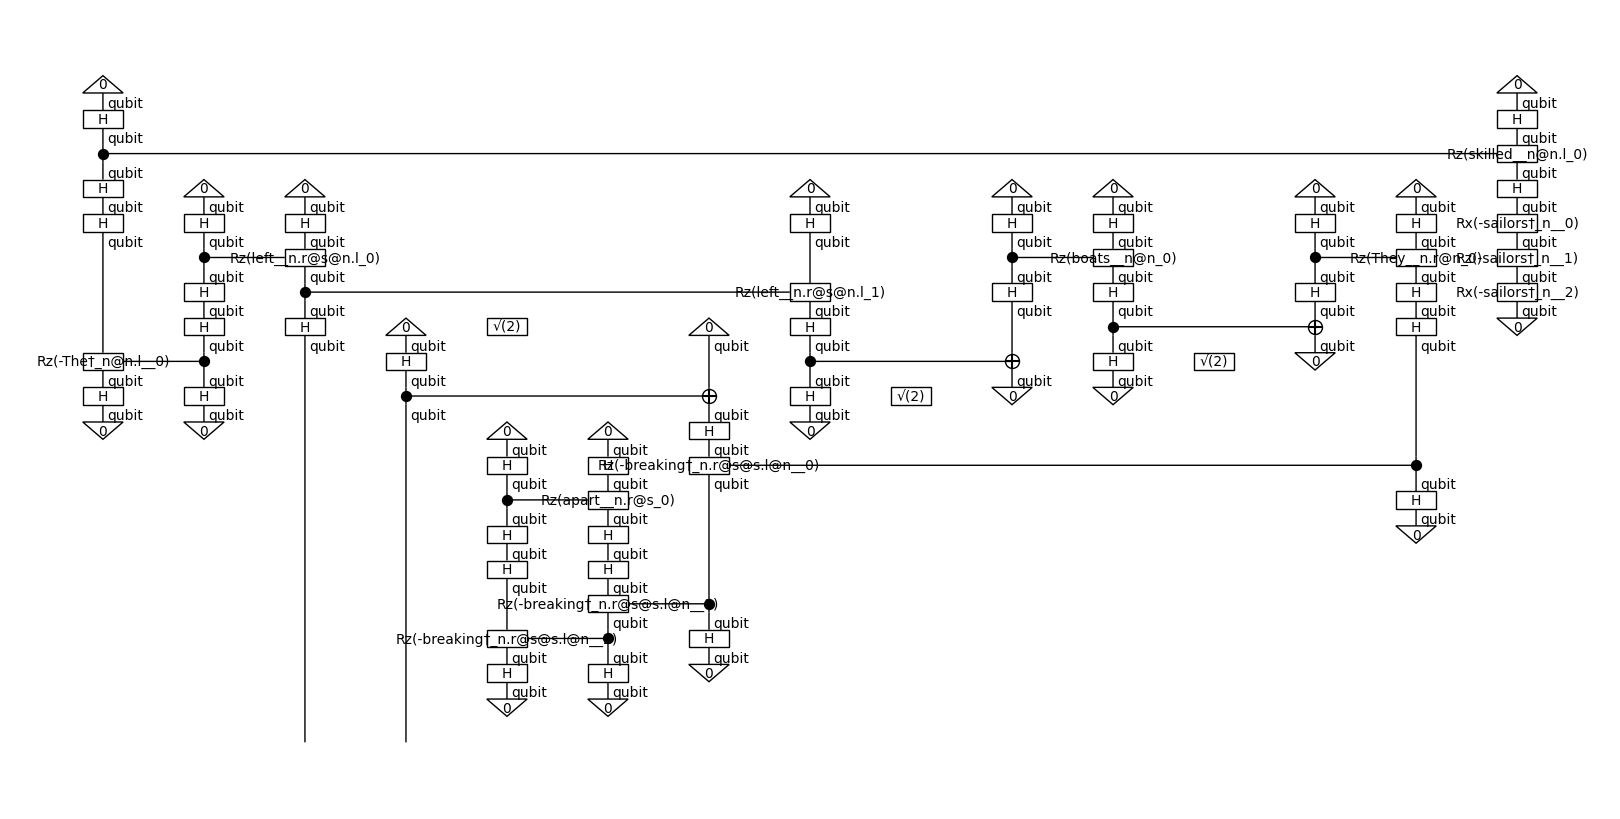

In [149]:
diag.draw(figsize=(16, 8))

In [150]:
# diag = diag.apply_gate(RY, 1)
# diag.draw(figsize=(16, 8))

In [155]:
diagXX = diag.apply_gate(Ry(0),0)
diagXX = diagXX.apply_gate(Ry(np.pi/8),1)

diagXZ = diag.apply_gate(Ry(0),0)
diagXZ = diagXZ.apply_gate(Ry(3*np.pi/8),1)

diagZX = diag.apply_gate(Ry(np.pi/4),0)
diagZX = diagZX.apply_gate(Ry(np.pi/8),1)

diagZZ = diag.apply_gate(Ry(np.pi/4),0)
diagZZ = diagZZ.apply_gate(Ry(3*np.pi/8),1)

# diagZX = diag.apply_gate(H,0)

# diagXZ = diag.apply_gate(H,1)

# diagZZ = diag.apply_gate(H,0)
# diagZZ = diagZZ.apply_gate(H,1)

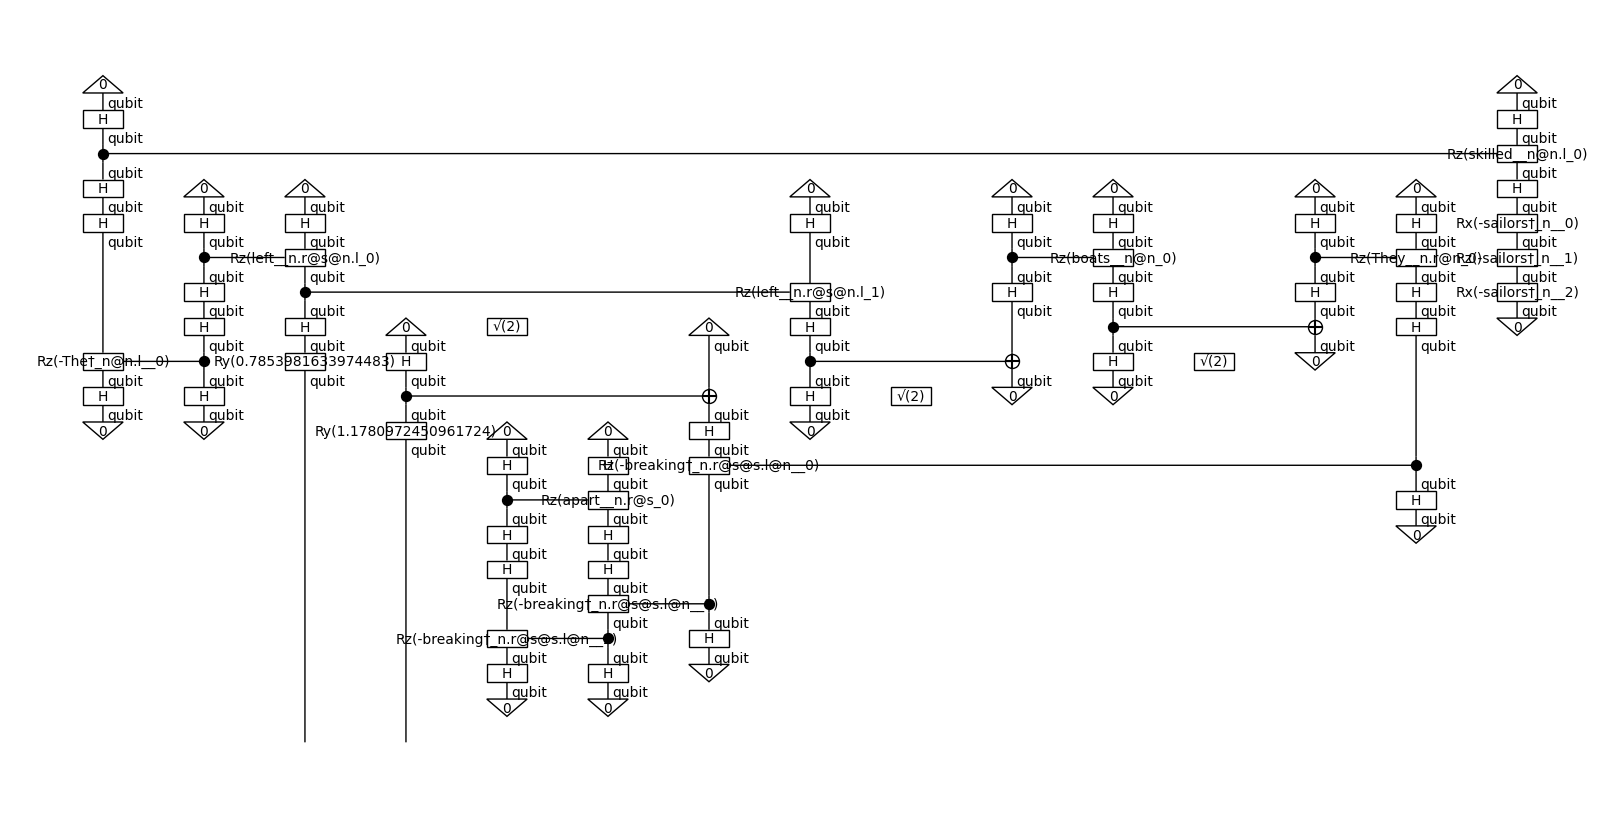

In [159]:
diagZZ.draw(figsize=(16, 8))

In [160]:
probabilities = best_model.get_diagram_output([diagZZ])[0]
print(probabilities)

[[0.06207847 0.53977356]
 [0.04243198 0.35571599]]


In [173]:
def gen_emp(diags: [Diagram], model: NumpyModel) -> Model:
    cy_sc = CyclicScenario(['a','b','A','B'],2)
    prob_dist = []
    for diag in diags:
        prob_dist.append(model.get_diagram_output([diag])[0].flatten())
    return Model(cy_sc, prob_dist)

In [168]:
tmp = gen_emp([diagXX, diagZX, diagXZ, diagZZ], best_model)

In [169]:
print(tmp.contextual_fraction())
print(tmp.signalling_fraction())

0.8729815496486709
0.8729815496468714


In [171]:
tmp.CbD_measure()

-5.744710771047698